In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sparse
import h5py

# Load file, the cortex model of voxel level

In [5]:
file = h5py.File("raw_data/NSR_data_May22.mat", "r")
dti = file["NSR_dti_net_full"][:]  # voxel to voxoel
gm = file["NSR_dti_grey_matter"][:].squeeze()  # gray matter at voxel level
synapse_scale = file["NSR_voxel_Synapsis"][:].squeeze()  # synapse scale at voxel level

conn = dti / dti.sum(axis=1, keepdims=True)
conn = sparse.COO(conn)
dti = sparse.COO(dti)
num_voxel = gm.shape[0]
print("density", dti.density)
print("size", gm.shape[0])

density 0.01733077658909178
size 16043


Text(0.5, 0, 'dti')

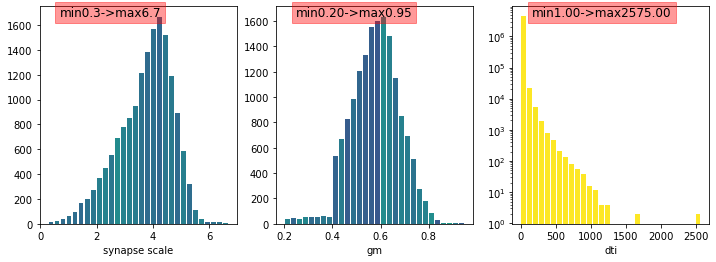

In [9]:
cmap = plt.cm.viridis_r
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
cnts, values, bars = ax[0].hist(synapse_scale, bins=30, rwidth=0.8, log=False)
newvalue = (synapse_scale - synapse_scale.min()) / (synapse_scale.max() - synapse_scale.min())
for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[0].text(0.1, 1.0, f"min{synapse_scale.min():.1f}->max{synapse_scale.max():.1f}", transform=ax[0].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[0].set_xlabel("synapse scale")

cnts1, values1, bars1 = ax[1].hist(gm, bins=30, rwidth=0.8)
newvalue = (gm - gm.min()) / (gm.max() - gm.min())
for i, (cnt, value, bar) in enumerate(zip(cnts1, values1, bars1)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[1].text(0.1, 1.0, f"min{gm.min():.2f}->max{gm.max():.2f}", transform=ax[1].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[1].set_xlabel("gm")

cnts1, values1, bars1 = ax[2].hist(dti.data, bins=30, rwidth=0.8, log=True)
newvalue = (dti.data - dti.data.min()) / (dti.data.max() - dti.data.min())
for i, (cnt, value, bar) in enumerate(zip(cnts1, values1, bars1)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[2].text(0.1, 1.0, f"min{dti.data.min():.2f}->max{dti.data.max():.2f}", transform=ax[2].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[2].set_xlabel("dti")

# Process to population level

## suppose:
- the same neuronal density among cortical voxels and thus number of neurons in each voxel is proportional to the gray matter.
- the synapse scale is the related correlation of total synapse to voxels.
- the local connectivity is wired according to the mciro-circuit, and the voxel-voxel connectivity is obeying the correlation as DTI.
- the inner/outer synapse for voxel of V1 is 2.8/1 (originated from 10*11 table of micro-circuit), and we can compute the outer ratio for other voxel $r_{j}$ by
$$\dfrac{syn_{v1} * r_{v1}}{syn_{j} * r_{j}}=\dfrac{\text{row sum}\,dti_{v1}}{\text{row sum}\,dti_{j}}$$

### The fourth point design has not been used

In [14]:
def _add_laminar_cortex_model(conn_prob, gm, synapse):
    """
    Process the connection probability matrix, grey matter and degree scale for DTB with pure voxel and micro-column
    structure.  Each voxel is split into 2 populations (E and I). Each micro-column is spilt into 10 populations
    (L1E, L1I, L2/3E, L2/3I, L4E, L4I, L5E, L5I, L6E, L6I).

    Parameters
    ----------
    conn_prob: numpy.ndarray, shape [N, N]
        the connectivity probability matrix between N voxels/micro-columns.

    gm: numpy.ndarray, shape [N]
        the normalized grey matter in each voxel/micro-column.

    canonical_voxel: bool
        Ture for voxel structure; False for micro-column structure.

    Returns
    -------
    out_conn_prob: numpy.ndarray
        connectivity probability matrix between populations (shape [2*N, 2*N] for voxel; shape[10*N, 10*N] for micro
        -column) in the sparse matrix form.

    out_gm: numpy.ndarray
        grey matter for populations in DTB (shape [2*N] for voxel; shape[10*N] for micro-column).

    out_degree_scale: numpy.ndarray
        scale of degree for populations in DTB (shape [2*N] for voxel; shape[10*N] for micro-column).

    """
    lcm_connect_prob = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 3554, 804, 881, 45, 431, 0, 136, 0, 1020],
                                 [0, 0, 1778, 532, 456, 29, 217, 0, 69, 0, 396],
                                 [0, 0, 417, 84, 1070, 690, 79, 93, 1686, 0, 1489],
                                 [0, 0, 168, 41, 628, 538, 36, 0, 1028, 0, 790],
                                 [0, 0, 2550, 176, 765, 99, 621, 596, 363, 7, 1591],
                                 [0, 0, 1357, 76, 380, 32, 375, 403, 129, 0, 214],
                                 [0, 0, 643, 46, 549, 196, 327, 126, 925, 597, 2609],
                                 [0, 0, 80, 8, 92, 3, 159, 11, 76, 499, 1794]], dtype=np.float64
                                )

    lcm_gm = np.array([0, 0,
                       33.8 * 78, 33.8 * 22,
                       34.9 * 80, 34.9 * 20,
                       7.6 * 82, 7.6 * 18,
                       22.1 * 83, 22.1 * 17], dtype=np.float64)  # ignore the L1 neurons
    with np.errstate(divide='ignore', invalid='ignore'):
        lcm_connect_prob = lcm_connect_prob * lcm_gm[:, None]
        lcm_gm = lcm_gm / lcm_gm.sum()
    weight = lcm_gm[::2]
    weight = weight / weight.sum(axis=0)
    weight = np.broadcast_to(weight, (conn_prob.data.shape[0], 5))


    lcm_connect_prob = lcm_connect_prob / np.sum(lcm_connect_prob)
    degree_scale = lcm_connect_prob.sum(axis=1) / lcm_connect_prob.sum()
    degree_scale = synapse[:, None] * degree_scale[None, :]
    degree_scale = degree_scale.reshape(-1)

    corrds1 = np.empty(
        [4, conn_prob.coords.shape[1] * lcm_connect_prob.shape[0] * int(lcm_connect_prob.shape[0] / 2)],
        dtype=np.int64)
    corrds1[3, :] = np.tile(np.repeat(np.arange(0, lcm_connect_prob.shape[0], 2), lcm_connect_prob.shape[0]),
                            conn_prob.coords.shape[1]).reshape([1, -1])

    corrds1[(0, 2), :] = np.broadcast_to(conn_prob.coords[:, :, None],
                                         [2, conn_prob.coords.shape[1],
                                          lcm_connect_prob.shape[0] * int(lcm_connect_prob.shape[0] / 2)]).reshape(
        [2, -1])
    corrds1[(1), :] = np.broadcast_to(np.arange(lcm_connect_prob.shape[0], dtype=np.int64)[None, :],
                                      [conn_prob.coords.shape[1] * int(lcm_connect_prob.shape[0] / 2),
                                       lcm_connect_prob.shape[0]]).reshape([1, -1])

    data1 = conn_prob.data[:, None] * lcm_connect_prob[:, -1]
    data1 = (data1[:, None, :] * weight[:, :, None]).reshape([-1])

    lcm_connect_prob_inner = sparse.COO(lcm_connect_prob[:, :-1])
    corrds2 = np.empty([4, conn_prob.shape[0] * lcm_connect_prob_inner.data.shape[0]], dtype=np.int64)
    corrds2[0, :] = np.broadcast_to(np.arange(conn_prob.shape[0], dtype=np.int64)[:, None],
                                    [conn_prob.shape[0], lcm_connect_prob_inner.data.shape[0]]).reshape([-1])
    corrds2[2, :] = corrds2[0, :]
    corrds2[(1, 3), :] = np.broadcast_to(lcm_connect_prob_inner.coords[:, None, :],
                                         [2, conn_prob.shape[0], lcm_connect_prob_inner.coords.shape[1]]).reshape(
        [2, -1])
    data2 = np.reshape(np.broadcast_to(lcm_connect_prob_inner.data[None, :], (conn_prob.shape[0], lcm_connect_prob_inner.data.shape[0])), [-1])

    coords = np.concatenate([corrds1, corrds2, ], axis=1)
    data = np.concatenate([data1, data2], axis=0)
    shape = [conn_prob.shape[0], lcm_connect_prob.shape[0], conn_prob.shape[1],
             lcm_connect_prob.shape[1] - 1]

    index = np.where(data)[0]
    print(f"process zero value in conn_prob {len(data)}-->{len(index)}")
    coords = coords[:, index]
    data = data[index]

    out_conn_prob = sparse.COO(coords=coords, data=data, shape=shape)
    out_conn_prob = out_conn_prob.reshape((conn_prob.shape[0] * lcm_connect_prob.shape[0],
                                           conn_prob.shape[1] * (lcm_connect_prob.shape[1] - 1)))

    gm /= gm.sum()
    out_gm = (gm[:, None] * lcm_gm[None, :]).reshape([-1])

    return out_conn_prob, out_gm, degree_scale

process zero value in conn_prob 223926308-->143636264


Text(0.5, 0, 'detailed degree')

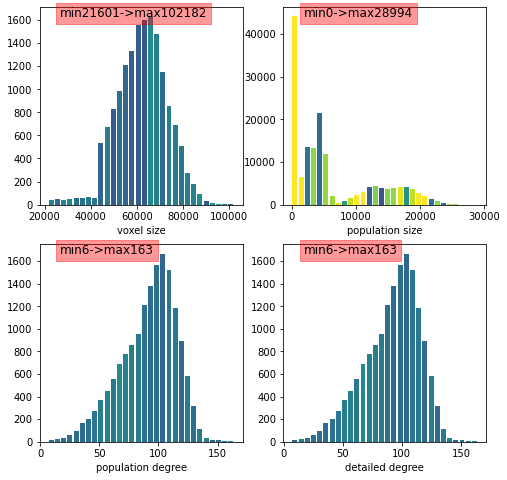

In [15]:
degree = 100
scale = int(1e9)

conn_prob, block_size, degree_scale = _add_laminar_cortex_model(conn, gm, synapse_scale)

hpc_label = file["NSR_dti_HCPex_label"][:].squeeze()
v1_index = np.where(hpc_label==181)[0]
v1_synapse_scale = synapse_scale[v1_index].mean()
# suppose v1 synapse is 100, then we assign number of synapse to all voxel
degree_ = synapse_scale / v1_synapse_scale * degree

popu_size = (block_size * scale).astype(np.int32)
voxel_size = popu_size.reshape((-1, 10)).sum(axis=1)

degree_detail = degree_[degree_<500]
fig, ax= plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()

for idx, value in enumerate([voxel_size, popu_size, degree_, degree_detail]):
    cnts, values, bars = ax[idx].hist(value, bins=30, rwidth=0.8)
    newvalue = (value - value.min()) / (value.max() - value.min())
    for i, (cnt, value_data, bar) in enumerate(zip(cnts, values, bars)):
        bar.set_facecolor(cmap(newvalue[i]))
    ax[idx].text(0.1, 1.0, f"min{int(value.min())}->max{int(value.max())}", transform=ax[idx].transAxes, va='top',fontsize=12,
              bbox={'color':'r','alpha':0.4,})
    ax[idx].set_xlabel("numbers")
ax[0].set_xlabel("voxel size")
ax[1].set_xlabel("population size")
ax[2].set_xlabel("population degree")
ax[3].set_xlabel("detailed degree")